目录

* [训练XGBoost简单demo](#训练XGBoost简单demo)
* [交叉验证](#交叉验证)
* [进阶操作-调整样本权重](#进阶操作-调整样本权重)
* [进阶操作-自定义目标函数（损失函数）](#进阶操作-自定义目标函数（损失函数）)
* [用前n棵树做预测](#用前n棵树做预测)
* [绘制特征重要度](#绘制特征重要度)
* [与sklearn组合使用](#与sklearn组合使用)
* [优化超参数-网格搜索](#优化超参数-网格搜索)

【注意】：
xgboost有2套python API：1个是原生api，1个是sklearn 风格的api。为了确定估计器的数目，也就是boosting迭代的次数，也可以说是残差树的数目，
参数名为n_estimators、num_iterations、num_round、num_boost_round都是等价的，都是num_boost_round的别名

**api官方文档：**
- [原生Python api文档](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.training)
- [sklearn风格api文档](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)

下面的示例中先介绍原生api的使用，后面再介绍sklearn 风格的api的使用

## 训练XGBoost简单demo

先指定一组参数param，如何去训练

In [3]:
# 数据是libsvm格式，很适合用于**稀疏存储**的数据：
# 例如 0 1:1 9:1 19:1 21:1 24:1 ...
# 第1列是target 后面是index:数值

import numpy as np
import scipy.sparse
import pickle # python2中叫cPickle python3中改为pickle
import xgboost as xgb

cwd = '/home/xijian/pycharm_projects/Magic-NLPer/MachineLearning/'
data_dir = cwd+'XGBoostUsage/data/'

In [4]:
# 读取数据集
# xgb.DMatrix()可以直接读取libsvm格式的数据
dtrain = xgb.DMatrix(data_dir + 'agaricus.txt.train')
dtest = xgb.DMatrix(data_dir + 'agaricus.txt.test')

In [28]:
# 设定模型参数
param = {'max_depth':2,  # 树深
         'eta': 1,
         'verbosity': 0,
         'objective': 'binary:logistic'}
watch_list = [(dtest, 'eval'), (dtrain, 'train')]
number_round = 10 # 跑10轮（10棵子树） # 通用参数
# 训练
model = xgb.train(param, dtrain, num_boost_round=number_round, evals=watch_list)

[0]	eval-error:0.04283	train-error:0.04652
[1]	eval-error:0.02173	train-error:0.02226
[2]	eval-error:0.00621	train-error:0.00706
[3]	eval-error:0.01800	train-error:0.01520
[4]	eval-error:0.00621	train-error:0.00706
[5]	eval-error:0.00000	train-error:0.00123
[6]	eval-error:0.00000	train-error:0.00123
[7]	eval-error:0.00000	train-error:0.00123
[8]	eval-error:0.00000	train-error:0.00123
[9]	eval-error:0.00000	train-error:0.00000


In [6]:
# 预测
pred = model.predict(dtest) # 返回的是numpy.array
print(type(pred), pred.dtype, pred.shape) # (1611,)

<class 'numpy.ndarray'> float32 (1611,)


In [7]:
# groundtruth
labels = dtest.get_label()
print(type(labels), labels.dtype, labels.shape)
print(labels[:10])

<class 'numpy.ndarray'> float32 (1611,)
[0. 1. 0. 0. 0. 0. 1. 0. 1. 0.]


In [8]:
error_num = sum([i for i in range(len(pred)) if int(pred[i]>0.5)!=labels[i]])
print(error_num)

0


## 交叉验证

In [29]:
number_round = 5 # 通用参数
# nfold=5折
xgb.cv(param, dtrain, number_round, nfold=5, metrics={'error'}, seed=3)

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.046522,0.001200,0.046523,0.004801
1,0.022263,0.000867,0.022263,0.003470
2,0.007063,0.000506,0.007062,0.002023
3,0.015200,0.001074,0.015199,0.004295
4,0.007063,0.000506,0.007062,0.002023


## 调整样本权重

In [30]:
# 看一下正负例的比例，然后调整一下权重
def preproc(dtrain, dtest, param):
    labels = dtrain.get_label()
    ratio = float(np.sum(labels==0))/np.sum(labels==1)
    param['scale_pos_ratio'] = ratio
    return (dtrain, dtest, param)

xgb.cv(param, dtrain, number_round, nfold=5, metrics={'auc'}, seed=3, fpreproc=preproc)
# auc值越接近1效果越好

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.958229,0.000999,0.958240,0.004015
1,0.981414,0.000701,0.981429,0.002824
2,0.997069,0.000423,0.997046,0.001723
3,0.998758,0.000123,0.998769,0.000500
4,0.999332,0.000097,0.999201,0.000382


## 进阶操作-自定义目标函数（损失函数）

目标函数：预测与label的接近程度，值越大越好，梯度上升

损失函数：预测与label的差距程度，值越小越好，梯度下降

xgboost中如果要使用自定义目标函数，就要自己提供一阶导数和二阶导数的实现

【注意】：
在逻辑回归章节，求导时，梯度=X.T.dot(h_x-y)，为什么上面只写了(h_x-y)？

因为：这里的p-y.label，其实只是梯度的“公共部分”，因为不同的样本要乘以各自的样本值，所以是无法提前算出来的，
因此往往用p-y.label计算梯度的系数部分，实际拿到样本，再乘以各自的数据。


In [37]:
# 自定义目标函数：log似然，交叉验证
# 需要提供一阶导数和二阶导数
def logregobj(pred, dtrain):
    labels = dtrain.get_label()
    pred = 1. / (1+np.exp(-pred)) # sigmoid
    grad = pred - labels # 1阶导数
    hess = pred*(1-pred) # 2阶导数（海森矩阵），sigmoid的导数：g'(x)=g(x)(1-g(x))
    return grad, hess
"""
在逻辑回归章节，求导时，梯度=X.T.dot(h_x-y)，为什么上面只写了(h_x-y)
这里的p-y.label，其实只是梯度的“公共部分”，因为不同的样本要乘以各自的样本值，
所以是无法提前算出来的，因此往往用p-y.label计算梯度的系数部分，实际拿到样本，再乘以各自的数据。
"""

def evalerror(pred, dtrain):
    labels = dtrain.get_label()
    error_num = float(sum(labels!=(pred>0.))) # sigmoid函数g(z)>0.5的话，要z>0.
    return 'error', error_num/len(labels)

# 模型参数
param = {'max_depth':2,  # 树深
         'eta': 1,
         'verbosity': 0,}
watch_list = [(dtest, 'eval'), (dtrain, 'train')]
number_round = 5 # 通用参数

# 自定义目标函数训练
model = xgb.train(param, dtrain,
                  num_boost_round=number_round,
                  evals=watch_list,
                  obj=logregobj, # 目标函数
                  feval=evalerror) # 评价函数

[0]	eval-rmse:1.59229	train-rmse:1.59597	eval-error:0.04283	train-error:0.04652
[1]	eval-rmse:2.40519	train-rmse:2.40977	eval-error:0.02173	train-error:0.02226
[2]	eval-rmse:2.88253	train-rmse:2.87459	eval-error:0.00621	train-error:0.00706
[3]	eval-rmse:3.62808	train-rmse:3.63621	eval-error:0.01800	train-error:0.01520
[4]	eval-rmse:3.80794	train-rmse:3.83893	eval-error:0.00621	train-error:0.00706


In [35]:
# 5折
xgb.cv(param, dtrain, number_round, nfold=5, seed=3, obj=logregobj, feval=evalerror)

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std,train-error-mean,train-error-std,test-error-mean,test-error-std
0,1.594727,0.001794,1.594569,0.017434,0.046522,0.001200,0.046523,0.004801
1,2.403623,0.005003,2.403480,0.030395,0.022263,0.000867,0.022263,0.003470
2,2.856625,0.011625,2.855065,0.033168,0.007063,0.000506,0.007062,0.002023
3,3.619403,0.016150,3.617983,0.029252,0.015200,0.001074,0.015199,0.004295
4,3.804502,0.030278,3.810880,0.048983,0.005988,0.002618,0.005527,0.001488


## 用前n棵树做预测

number_round = 5 做了5轮，就会有5棵树产生

但是可以仅使用前几棵树做预测

In [13]:
pred1 = model.predict(dtest, ntree_limit=1)
print(evalerror(pred1, dtest))

('error', 0.04283054003724395)


In [14]:
pred2 = model.predict(dtest, ntree_limit=2)
print(evalerror(pred2, dtest))

('error', 0.021725636250775917)


In [38]:
pred3 = model.predict(dtest, ntree_limit=3)
print(evalerror(pred3, dtest))

('error', 0.006207324643078833)


## 绘制特征重要度

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

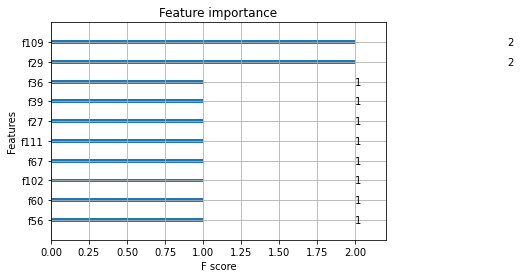

In [39]:
%matplotlib inline
from xgboost import plot_importance
from matplotlib import pyplot as plt

plot_importance(model, max_num_features=10)

## 与sklearn组合使用

使用sklearn中自带的数据集，如手写数字（10分类问题）、鸢尾花（3分类问题）

sklearn中的KFold、train_test_split等都可以组合使用

下面xgboost的使用，也主要使用sklearn风格的API，例如xxClassifier，xxRegressor、fit、predict等

In [17]:
import pickle
import xgboost as xgb
import numpy as np

from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.datasets import load_iris, load_digits, load_boston

# 10分类问题
# 用XGBoost建模，用sklearn做评估，这里使用混淆矩阵进行评估
# 加载数据(手写数字)
digits = load_digits()
print(digits.keys())
y = digits['target']
X = digits['data']
print(X.shape) # (1797, 64)
print(y.shape)

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])
(1797, 64)
(1797,)


In [19]:
# K折切分器
kf = KFold(n_splits=2, shuffle=True, random_state=1234) # 2折
for train_index, test_index in kf.split(X):
    # 这里model没做任何param的设定，全使用默认值
    xgb_model = xgb.XGBClassifier().fit(X[train_index], y[train_index])
    pred = xgb_model.predict(X[test_index])
    ground_truth = y[test_index]
    print(confusion_matrix(ground_truth, pred))
    print()

[[ 78   0   0   0   0   0   0   0   1   0]
 [  0  90   0   0   0   1   0   0   0   2]
 [  0   1  82   0   0   0   3   0   0   0]
 [  0   0   1  89   0   0   0   1   0   3]
 [  2   0   0   0 101   0   1   2   1   0]
 [  0   0   0   1   0  96   2   0   0   3]
 [  0   3   0   0   1   0  83   0   1   0]
 [  0   0   0   0   1   0   0  86   0   1]
 [  0   6   1   3   0   1   0   0  71   0]
 [  0   0   0   0   1   1   0   5   2  71]]

[[97  0  0  0  0  1  0  1  0  0]
 [ 0 86  0  1  0  0  1  0  0  1]
 [ 0  0 90  1  0  0  0  0  0  0]
 [ 0  1  0 86  0  1  0  0  1  0]
 [ 0  1  0  0 72  0  0  0  0  1]
 [ 1  0  0  0  0 72  0  0  2  5]
 [ 1  0  0  0  0  1 91  0  0  0]
 [ 0  0  0  0  0  0  0 90  1  0]
 [ 1  2  0  0  0  1  0  2 85  1]
 [ 0  6  0  1  0  1  0  0  1 91]]



In [20]:
# 3分类问题（鸢尾花）
iris = load_iris()
y_iris = iris['target']
X_irsi = iris['data']

kf = KFold(n_splits=2, shuffle=True, random_state=1234) # 2折
for train_index, test_index in kf.split(X_irsi):
    xgb_model = xgb.XGBClassifier().fit(X_irsi[train_index], y_iris[train_index])
    pred = xgb_model.predict(X_irsi[test_index])
    ground_truth = y_iris[test_index]
    print(confusion_matrix(ground_truth, pred))
    print()

[[25  0  0]
 [ 0 24  1]
 [ 0  0 25]]

[[25  0  0]
 [ 0 23  2]
 [ 0  1 24]]



In [27]:
# 回归问题（boston房价预测）
boston = load_boston()
# print(type(boston))
X_boston = boston['data']
y_boston = boston['target']

kf = KFold(n_splits=2, shuffle=True, random_state=1234) # 2折
for train_index, test_index in kf.split(X_boston):
    # 这里使用回归器：XGBRegressor
    xgb_model = xgb.XGBRegressor().fit(X_boston[train_index], y_boston[train_index])
    pred = xgb_model.predict(X_boston[test_index])
    ground_truth = y_boston[test_index]
    # 回归问题，所以评估换成mse
    print('mse:', mean_squared_error(ground_truth, pred))
    print()

mse: 11.431804163616869

mse: 15.365480950058584



## 优化超参数-网格搜索

In [40]:
# 回归问题（boston房价预测）
boston = load_boston()
X_boston = boston['data']
y_boston = boston['target']
xgb_model = xgb.XGBRegressor()

# 参数字典
param_dict = {'max_depth': [2,4,6], # 最大树深
              'n_estimators': [50, 100, 200]} # 树的棵树

rgs = GridSearchCV(xgb_model, param_dict)
rgs.fit(X_boston, y_boston)

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
      

In [24]:
print(rgs.best_params_)

{'max_depth': 2, 'n_estimators': 100}
